## Tutorial number 1
### Working with ethoscope data
The tutorial will guide you through loading data, visualisation and plotting using the common sleep functions

## 1. Load the dummy dataset

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from math import floor, ceil, sqrt
from scipy.stats import zscore
from functools import partial, update_wrapper
from colour import Color

from ethoscopy.behavpy_draw import behavpy_draw

from ethoscopy.misc.circadian_bars import circadian_bars
from ethoscopy.analyse import max_velocity_detector
from ethoscopy.misc.rle import rle
from ethoscopy.misc.bootstrap_CI import bootstrap
from ethoscopy.misc.hmm_functions import hmm_pct_transition, hmm_mean_length, hmm_pct_state
from ethoscopy.misc.static_functions import concat

import ethoscopy as etho
import seaborn as sns

In [2]:
# This tutorial requires version 1.1.7 or greater
etho.__version__

'2.0.dev0'

In [3]:
# d = pd.read_pickle('/home/lab/Desktop/ethoscopy/tutorial_notebook/response_d.pkl')
# m = pd.read_pickle('/home/lab/Desktop/ethoscopy/tutorial_notebook/response_m.pkl')
# df = etho.behavpy(d, m, check = True, canvas = 'seaborn')
# df.meta['exp'] = df.meta['odour'] + '-' + df.meta['rest']
# fargs =  ['air-first day', 'air-second day']#, 'air-third day', 'air-fourth day', 'air-fifth day', '5% AA-first day', '5% AA-second day', '5% AA-third day', '5% AA-fourth day', '5% AA-fifth day']
# df.canvas

In [4]:
df1 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_1_data_c.pkl')
df2 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_2_data_c.pkl')
pdf1 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_1_puff_c.pkl')
pdf2 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_2_puff_c.pkl')
df = etho.concat(df1, df2)
pdf = etho.concat(pdf1, pdf2)
df = etho.behavpy(df, df.meta, check = True, canvas = 'seaborn')
pdf = etho.behavpy(pdf, pdf.meta, check = True, canvas = 'seaborn')

In [5]:
tdf = df.xmv('date', '2024-03-14')
tpdf = pdf.xmv('date', '2024-03-14')

In [6]:
# tpdf = tpdf[tpdf['has_interacted'] == 1]

In [14]:
def plot_response_over_activity(df, mov_df, activity, variable = 'moving', response_col = 'has_responded', facet_col = None, facet_arg = None, facet_labels = None, x_limit = 30, title = '', t_column = 't', grids = False, figsize = (0,0)):
    """ A plotting function for AGO or mAGO datasets that have been loaded with the analysing function stimulus_response.
        Generate a plot which shows how the response response rate changes over time inactive or active.

        Args:
            mov_df (behavpy dataframe): The matching behavpy dataframe containing the movement data from the response experiment
            activity (str): A choice to display reponse rate for continuous bounts of inactivity, activity, or both. Choice one of ['inactive', 'active', 'both']
            variable (str, optional): The name of column in the movement dataframe that has the boolean movement values. Default is 'moving'.
            response_col (str, optional): The name of the coloumn that has the responses per interaction. Must be a column of bools. Default is 'has_responded'.
            facet_col (str, optional): The name of the column to use for faceting, must be from the metadata. Default is None.
            facet_arg (list, optional): The arguments to use for faceting. If None then all distinct groups will be used. Default is None.
            facet_labels (list, optional): The labels to use for faceting, these will be what appear on the plot. If None the labels will be those from the metadata. Default is None.
            x_limit (int, optional): A number to limit the x-axis by to remove outliers, i.e. 30 would be 30 minutes or less if t_bin is 60. Default 30.
            t_bin (int, optional): The time in seconds to bin the time series data to. Default is 60.
            title (str, optional): The title of the plot. Default is an empty string.
            t_column (str, optional): The name of column containing the timing data (in seconds). Default is 't'.
            grids (bool, optional): true/false whether the resulting figure should have grids. Default is False.
            figsize (tuple, optional): The size of the figure in inches. Default is (0, 0) which auto-adjusts the size.

    Returns:
        fig (matplotlib.figure.Figure): Figure object of the plot.
        
    Notes:
        This plotting method can show the response rate for both active and inactive bouts for the 
            whole dataset, but only for one or the other if you want to facet by a column, i.e. facet_col.
        This function must be called on a behavpy dataframe that is populated with data loaded with the stimulus_response
            analysing function.
    """        

    facet_arg, facet_labels = df._check_lists(facet_col, facet_arg, facet_labels)

    activity_choice = {'inactive' : 0, 'active' : 1, 'both' : (0, 1)}
    if activity not in activity_choice.keys():
        raise KeyError(f'activity argument must be one of {*activity_choice.keys(),}')
    if activity == 'both' and facet_col is not None:
        print('When plotting both inactive and active runs you can not use facet_col. Reverted to None')
        facet_col, facet_arg, facet_labels = None, [None], ['inactive', 'active']

    if facet_col and facet_arg:
        rdata = df.xmv(facet_col, facet_arg)
        # iterate over the filters and call the analysing function
        dfs = [rdata._bouts_response(mov_df=mov_df.xmv(facet_col, arg), hmm = False,
                variable=variable, response_col=response_col, labels=lab, colours=[], 
                x_limit=x_limit, t_bin=60, func='max', t_col=t_column) for arg, lab in zip(facet_arg, facet_labels)]
        grouped_data = pd.concat(dfs)
    else:
        grouped_data = df._bouts_response(mov_df=mov_df, hmm = False,
                                            variable=variable, response_col=response_col, labels=[], colours=[], 
                                            x_limit=x_limit, t_bin=60, func='max', t_col=t_column)
        inverse_dict = {v: k for k, v in activity_choice.items()}
        grouped_data['facet_col'] = grouped_data['previous_moving'].map(inverse_dict)

    # Get colours and labels, syncing them together and replacing False Stimuli with a grey colour
    palette = df._get_colours(facet_labels)
    grouped_data['label_col'] =  grouped_data['facet_col'] + " " + grouped_data['has_interacted']
    palette = [x for xs in [[col, col] for col in df._get_colours(facet_labels)] for x in xs]
    h_order = [f'{lab} {ty}' for lab in facet_labels for ty in ["Spon. Mov.", "True Stimulus"]]
    palette_dict = {name : df._check_grey(name, palette[c], response = True)[1] for c, name in enumerate(h_order)} # change to grey if control

    # If not both filter the dataset
    if isinstance(activity_choice[activity], int):
        grouped_data = grouped_data[grouped_data['previous_moving'] == activity_choice[activity]]

    # # create and style plot
    # fig = go.Figure() 
    # df._plot_ylayout(fig, yrange = [0, 1], t0 = 0, dtick = 0.2, ylabel = 'Response Rate', title = title, grid = grids)
    # df._plot_xlayout(fig, xrange = False, t0 = 0, dtick = 60/60, xlabel = f'Consecutive minutes in behavioural bout ({activity_choice[activity]})')

    # for hue in h_order:
    #     sub_df = grouped_data[grouped_data['label_col'] == hue]
    #     upper, trace, lower = df._plot_line(df = sub_df, x_col = 'previous_activity_count', name = hue, marker_col = palette_dict[hue])
    #     fig.add_trace(upper)
    #     fig.add_trace(trace) 
    #     fig.add_trace(lower)
    
    # return fig

    x_ticks = np.arange(1, x_limit, 1, dtype = int)

    if figsize == (0,0):
        figsize = ( 6 + 1/3 * len(x_ticks), 
                    8
                    )
        fig.set_size_inches(figsize)

    fig, ax = plt.subplots(figsize=figsize)
    plt.ylim([0, 1.01])
    plt.xlim([1, x_limit])

    for hue in h_order:

        sub_df = grouped_data[grouped_data['label_col'] == hue]

        plt.plot(sub_df["previous_activity_count"], sub_df["mean"], label = hue, color = palette_dict[hue])
        plt.fill_between(
        sub_df["previous_activity_count"], sub_df["y_min"], sub_df["y_max"], alpha = 0.25, color = palette_dict[hue]
        )

    # Customise legend values
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=h_order)
    
    plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=0)
    plt.xlabel(f'Consecutive minutes in behavioural bout ({activity_choice[activity]})')
    plt.ylabel("Response rate")

    plt.title(title)

    if grids:
        plt.grid(axis='y')

    return fig


In [15]:
x = plot_response_over_activity(tpdf, tdf, activity = 'inactive', variable = 'moving', facet_col = 'machine_name', facet_arg = None, facet_labels = None, title = '', t_column = 't', grids = False);
x

UnboundLocalError: cannot access local variable 'x_ticks' where it is not associated with a value

In [38]:
x['0_1']

,previous_activity_count,mean,count,y_max,y_min
0,1,0.219512,82,0.134146,0.304878
1,2,0.272727,55,0.163636,0.400000
2,3,0.210526,57,0.122807,0.315789
3,4,0.258065,31,0.096774,0.419355
4,5,0.217391,23,0.086957,0.391304
5,6,0.250000,16,0.062500,0.500000
6,7,0.176471,17,0.000000,0.352941
7,8,0.210526,19,0.052632,0.421053
8,9,0.000000,13,0.000000,0.000000
9,10,0.176471,17,0.000000,0.352941


In [5]:
# tdf = etho.behavpy(d, m, check = True, canvas = 'plotly')
# tdf.meta['exp'] = tdf.meta['odour'] + '-' + tdf.meta['rest']
# fig, stats_s = tdf.plot_response_quantify(title = '')
# fig.show()

In [6]:
# fig, stats_s = tdf.plot_quantify('x', facet_col = 'exp')
# fig.show()

In [7]:
# fig, stats_s = df.plot_quantify('x', facet_col = 'exp')

In [8]:
ndf = df[df['has_interacted'] == 1]

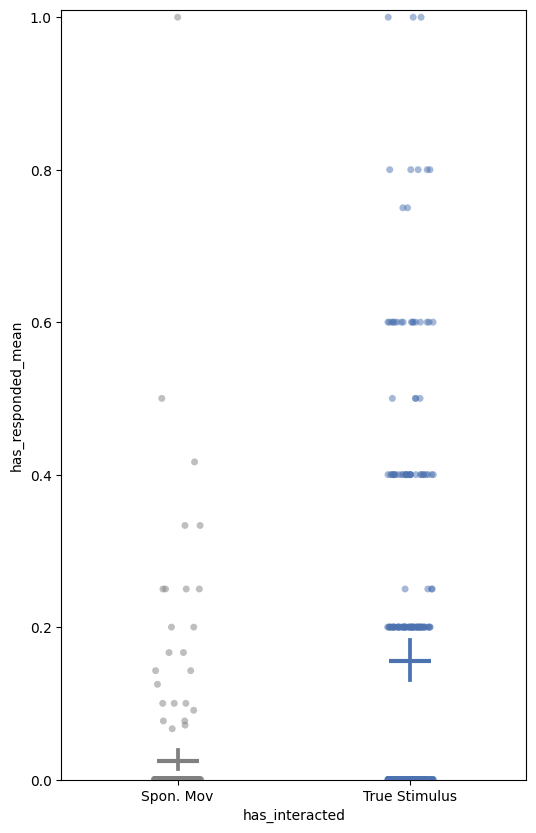

In [9]:
fig, stats_s = df.plot_response_quantify(title = '')
# fig.show()

In [10]:
['t', *['t', 't']]

['t', 't', 't']

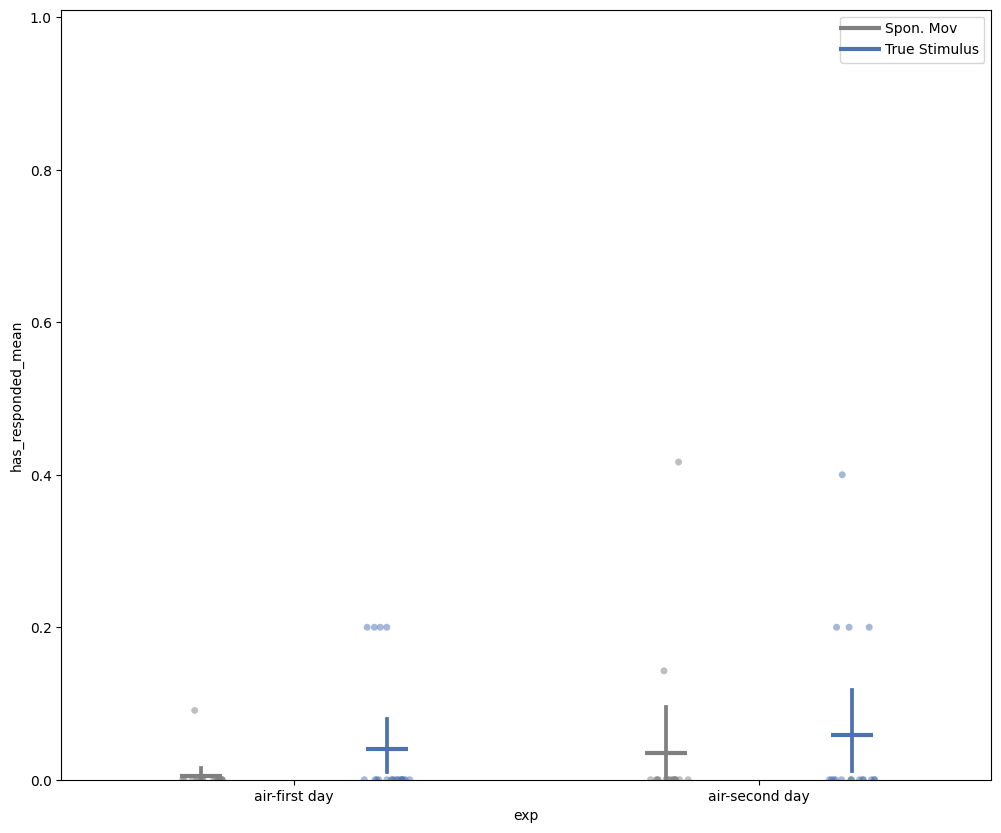

In [11]:
fig, stats_s = df.plot_response_quantify(facet_col = 'exp', facet_arg = fargs, title = '')

In [12]:
for i

SyntaxError: invalid syntax (2081252185.py, line 1)

In [ ]:
stats_s

In [ ]:
stats_s[stats_s['exp'] == 'air-first day'][stats_s[stats_s['exp'] == 'air-first day']['has_interacted'] == 'True Stimulus']

In [ ]:
df = etho.behavpy(d, m, check = True, canvas = 'plotly')
df.meta['exp'] = df.meta['odour'] + '-' + df.meta['rest']
fig, stats_p = df.plot_response_quantify(facet_col = 'exp', facet_arg = fargs, title = '')
fig.show()